In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from scipy.misc import imread
import matplotlib.patches as patches
from torch.utils.data import DataLoader
import cv2
import torch
from torch.autograd import  Variable
from faster_rcnn.utils.images import imshow
from faster_rcnn.fastrcnn.bbox_transform import bbox_transform
import cPickle

ImportError: No module named faster_rcnn.utils.images

In [3]:
with open('sorted_index', 'rb') as fp:
    sorted_index = cPickle.load(fp)

### Đọc dữ liệu từ MS COCO dataset


In [4]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.datasets.mscoco.dataset import CocoData
from faster_rcnn.utils.datasets.data_generator import CocoGenerator
from faster_rcnn.utils.datasets.data_generator import Enqueuer

dataDir = './data/mscoco'
dataType = 'train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
pre_proposal_folder = './data/mscoco/coco_proposals/MCG/'

images_dir = os.path.join(dataDir,'images', dataType)
cap = CocoData(root = images_dir, annFile = annFile)

data_gen = CocoGenerator(data=cap, sorted_index=sorted_index, batch_size=3)
queue = Enqueuer(generator=data_gen)
queue.start(max_queue_size=10, workers=2)
t = queue.get()


loading annotations into memory...
Done (t=9.66s)
creating index...
index created!


## RPN

#### Mục đích 

- Do Fast RCNN vẫn phụ thuộc vào Selective search để tính toán các proposal region dẫn đến kết quả tính toán rất chậm
- RPN dùng để tính toán proposal region mà không cần phụ thuộc vào các thuật toán khác

#### Cách hoạt động

- Sử dụng một cửa sổ trượt trên feature map
- tạo một network nhỏ để tính
    - Phân loạt một anchor có chứa hay không chưa object (Anchor good / bad)
    - Tính toán các trị số của proposal regions (box regression)
    
- Vị trí của cửa sổ trượt trên feature map, cho biết thông tin về vị trí của anchor trên ảnh gốc

#### Input

- Hình ảnh: là tensor có kích thước

    $[batchsize, dim, im\_height, im\_width]$
    
- bounding box:
    
    $(x_1, y_1, x_2, y_2)$

    - $x_1, y_1$ : tọa độ x,y của điểm trái dưới (lower-left)
    - $x_2, y_2$ : tọa độ x,y của điểm phải trên (top - right)

#### Output

- RPN classification (anchor good / bad)
- RPN regression (anchor -> proposal)

Cùng xem định dạng của một input

In [5]:
blobs = t.next()

In [6]:
max_height = np.max([blob['tensor'].shape[2] for blob in blobs])
max_width = np.max([blob['tensor'].shape[3] for blob in blobs])

In [7]:
batch_tensor = torch.Tensor(3, 3, max_height, max_width).fill_(0).type_as(blob['tensor'])

In [8]:
for i, blob in enumerate(blobs):
    shape = blob['tensor'].shape
    batch_tensor[i,:, :shape[2], :shape[3] ]= blob['tensor']

In [9]:
total_boxes = 0
batch_boxes = np.empty((0, 4))
batch_boxes_index = np.empty((0,), dtype=np.int)

for i, blob in enumerate(blobs):
    total_boxes = blob['boxes'].shape[0]
    batch_boxes = np.vstack((batch_boxes, blob['boxes']))
    a =  np.zeros((total_boxes , ), dtype=np.int)
    a.fill(i)
    batch_boxes_index = np.concatenate((batch_boxes_index, a), axis=0)
    
print batch_boxes_index
print batch_boxes

[0 0 1 1 1 2 2]
[[  48.57142857  465.71428571  537.14285714 1774.28571429]
 [ 220.         1065.71428571  382.85714286 1771.42857143]
 [ 326.76056338  315.49295775  394.36619718  580.28169014]
 [  76.05633803  290.14084507  242.25352113  788.73239437]
 [  11.26760563    8.45070423  585.91549296 1769.01408451]
 [ 178.125       221.875       287.5         975.        ]
 [ 321.875       334.375       434.375       984.375     ]]


Thử hiển thị ảnh cùng các bounding boxes

In [10]:
blobs[0]['boxes']

array([[  48.57142857,  465.71428571,  537.14285714, 1774.28571429],
       [ 220.        , 1065.71428571,  382.85714286, 1771.42857143]])

INFO:faster_rcnn.utils.datasets.mscoco.dataset:need more than 0 values to unpack


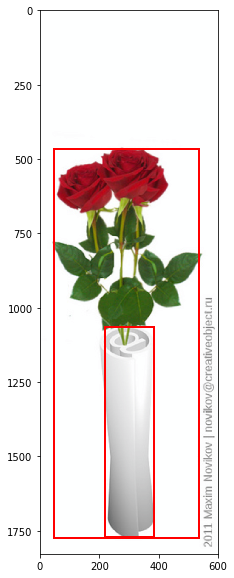

In [11]:
imshow(batch_tensor[0], blobs[0]['boxes'])

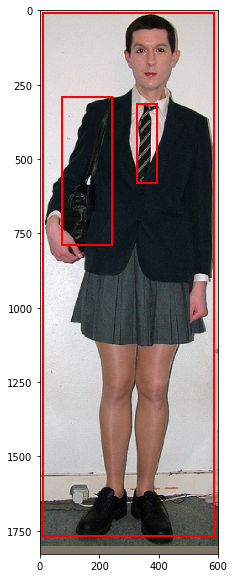

In [12]:
imshow(batch_tensor[1], blobs[1]['boxes'])

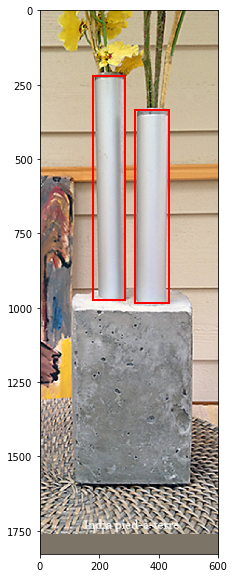

In [13]:
imshow(batch_tensor[2], blobs[2]['boxes'])

In [14]:
from faster_rcnn.faster_rcnn import  RPN
rpn_network = RPN()
rpn_network.cuda()

/data
/data/data/mscoco


faster_rcnn/network.py:26: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.conv.weight)


RPN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### Tính toán feed-forward


Chúng ta sử dụng một ảnh có kích thước đầu vào là  `(width , height) = (600, 800)`

Input:
    - im_data : 
        kích thước : (batch_size, dim, witdh, height)
    - ground_boxes: 
        kích thước (n, 4)
        

#### Tính `cnn features`  

Sử dụng mạng CNN đã được train trên Imagenet, cụ thể là VGG16 để tính toán `cnn features`

In [15]:
# convert tensor to variable
x = Variable(batch_tensor).cuda()
cnn_feature = rpn_network.features(x)

Chúng ta nhận được cnn_features có kích thước là  (37 , 50)

In [16]:
print cnn_feature.shape
print x.shape

torch.Size([3, 512, 114, 37])
torch.Size([3, 3, 1828, 600])


In [17]:
feature_height, feature_width = cnn_feature.shape[2], cnn_feature.shape[3]
im_height, im_width = x.shape[2] , x.shape[3]
batch_size = cnn_feature.shape[0]

### Nhận xét

Sau khi feed-forward một lần đối với ảnh gốc, thu được convolutional features của ảnh đó. Ví dụ với một hình ảnh có kích thước $600 * 800 * 3$, ta sẽ thu được convolutional features với kích thước $37 * 50 * 512$. Kích thước của features bị giảm nhỏ khoảng 16 lần $\frac{600}{37}$.

## AnchorTargerLayer

Sau khi thu được Convolutional Feature, chúng ta sẽ cùng tìm hiểu về AnchorTargetLayer.

### Vai trò của AnchorTargetlayer
    Gán cho anchor tương ứng với ground-truth boxes. 
    Tạo ra nhãn tương ứng cho từng anchor (bằng cách tính toán IOU)
    Tính giá trị mục tiêu của bounding-box regression

Tính toán đầu ra của RPN

- rpn_labels : (HxWxA, 1), for each anchor, 0 denotes bg, 1 fg, -1 dontcare
- rpn_bbox_targets: (HxWxA, 4), distances of the anchors to the gt_boxes(may contains some transform) that are the regression objectives
- rpn_bbox_inside_weights: (HxWxA, 4) weights of each boxes, mainly accepts hyper param in cfg
- rpn_bbox_outside_weights: (HxWxA, 4) used to balance the fg/bg, beacuse the numbers of bgs and fgs mays significiantly different

In [18]:
from faster_rcnn.rpn_msr.anchor_target_layer_2 import AnchorTargerLayer
anchor_target_layer = AnchorTargerLayer(feat_stride=[16,], anchor_scales=[8, 16 ,32])

#### Tạo các anchor tương ứng với vị trí ảnh tại vị trí [0. , 0. , 0., 0.]

In [19]:
features, rpn_bbox_pred, rpn_cls_score =  rpn_network._computer_forward(x)

In [20]:
im_info = torch.Tensor([[im_height, im_width]])
batch_boxes_index = torch.Tensor(batch_boxes_index)
batch_boxes = torch.Tensor(batch_boxes).numpy()




In [21]:
all_anchors = anchor_target_layer._create_anchors(feature_height, feature_width)
total_anchors = all_anchors.shape[0]

# only keep anchors inside the image
inside_anchors, inside_anchor_indexes = anchor_target_layer._filter_outside_anchors(
    all_anchors, im_height, im_width)
print all_anchors.shape
print inside_anchors.shape

(37962, 4)
(17098, 4)


In [22]:
inside_anchors.shape
inside_anchor_indexes.shape
print batch_boxes
print batch_boxes_index

[[  48.57143   465.7143    537.1429   1774.2858  ]
 [ 220.       1065.7142    382.85715  1771.4286  ]
 [ 326.76056   315.49295   394.3662    580.2817  ]
 [  76.056335  290.14084   242.25352   788.7324  ]
 [  11.267606    8.450705  585.91547  1769.014   ]
 [ 178.125     221.875     287.5       975.      ]
 [ 321.875     334.375     434.375     984.375   ]]
tensor([ 0.,  0.,  1.,  1.,  1.,  2.,  2.])


In [23]:
target = anchor_target_layer.calculate_target(inside_anchors, batch_size, inside_anchor_indexes, batch_boxes, batch_boxes_index.numpy())


In [24]:
result = anchor_target_layer((rpn_cls_score, torch.Tensor(batch_boxes), im_info, batch_boxes_index))
print(result[0][0].shape)

TypeError: forward() takes exactly 5 arguments (2 given)

In [ ]:
print target[0].shape
print target[1].shape
print result[0][1].numpy() == 1
print all_anchors.shape

In [ ]:
i = 2
imshow(batch_tensor[i], blobs[i]['boxes'] ,inside_anchors[target[0][i] == 1] )
# imshow(batch_tensor[i], blobs[i]['boxes'] ,all_anchors[result[0][i].numpy() == 0] )